In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('combined_articles.csv')

# Convert the timestamp to datetime for proper sorting
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Sort the dataframe by Article ID and Timestamp
df = df.sort_values(by=['Article ID', 'Timestamp'])


In [2]:
# Step-by-step implementation to compute M_r and M for each article

# Calculate M_r and M for each article separately
article_controversiality = []

# Iterate through each article
for article_id in df['Article ID'].unique():
    article_revisions = df[df['Article ID'] == article_id].reset_index(drop=True)
    
    # Identify reverts within this article
    reverts = []
    for i in range(2, len(article_revisions)):
        if article_revisions.loc[i, 'User/IP'] != article_revisions.loc[i-2, 'User/IP']:
            if article_revisions.loc[i, 'Revised Text'] == article_revisions.loc[i-2, 'Revised Text']:
                reverts.append({
                    'Reverter': article_revisions.loc[i, 'User/IP'],
                    'Reverted': article_revisions.loc[i-1, 'User/IP'],
                    'Reverter Index': i,
                    'Reverted Index': i-1
                })
    
    if not reverts:
        article_controversiality.append({'Article ID': article_id, 'M_r': 0, 'M': 0})
        continue
    
    reverts_df = pd.DataFrame(reverts)
    
    # Calculate total number of edits for each user in this article
    user_edit_counts = article_revisions.groupby('User/IP').size().reset_index(name='Total Edits')
    
    # Merge the edit counts with the reverts dataframe
    reverts_df = reverts_df.merge(user_edit_counts, left_on='Reverter', right_on='User/IP')
    reverts_df = reverts_df.rename(columns={'Total Edits': 'Reverter Total Edits'})
    reverts_df = reverts_df.merge(user_edit_counts, left_on='Reverted', right_on='User/IP')
    reverts_df = reverts_df.rename(columns={'Total Edits': 'Reverted Total Edits'})
    
    # Exclude self-reverts
    reverts_df = reverts_df[reverts_df['Reverter'] != reverts_df['Reverted']]
    
    # Calculate M_r
    reverts_df['Min Edits'] = reverts_df.apply(lambda row: min(row['Reverted Total Edits'], row['Reverter Total Edits']), axis=1)
    M_r = reverts_df['Min Edits'].sum()
    
    # Calculate the number of unique editors who ever reverted mutually
    unique_editors = pd.concat([reverts_df['Reverter'], reverts_df['Reverted']]).unique()
    E = len(unique_editors)
    
    # Compute M_i
    M_i = E * M_r
    
    # Find the maximum N^d or N^r
    max_edits = max(reverts_df['Reverted Total Edits'].max(), reverts_df['Reverter Total Edits'].max())
    
    # Censure the topmost mutually reverting editors
    censured_reverts_df = reverts_df[(reverts_df['Reverted Total Edits'] < max_edits) & (reverts_df['Reverter Total Edits'] < max_edits)]
    
    # Calculate the sum of the minimum of N^d and N^r for censured reverts
    censured_reverts_df['Min Edits'] = censured_reverts_df.apply(lambda row: min(row['Reverted Total Edits'], row['Reverter Total Edits']), axis=1)
    censured_M_r = censured_reverts_df['Min Edits'].sum()
    
    # Compute the final measure of controversiality M
    M = E * censured_M_r
    
    article_controversiality.append({'Article ID': article_id, 'M_r': M_r, 'M': M})

# Convert the result to a DataFrame
article_controversiality_df = pd.DataFrame(article_controversiality)

# Get the unique article titles and IDs
article_titles = df[['Article ID', 'Article Title']].drop_duplicates()

# Merge the article titles with the article controversiality dataframe
article_controversiality_df = article_controversiality_df.merge(article_titles, on='Article ID')

# Reorder columns for better readability
article_controversiality_df = article_controversiality_df[['Article ID', 'Article Title', 'M_r', 'M']]


article_controversiality_df.head()


/var/folders/5z/cnfqktn11n165g1nt0bbmbrh0000gn/T/ipykernel_52168/42463337.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  censured_reverts_df['Min Edits'] = censured_reverts_df.apply(lambda row: min(row['Reverted Total Edits'], row['Reverter Total Edits']), axis=1)
/var/folders/5z/cnfqktn11n165g1nt0bbmbrh0000gn/T/ipykernel_52168/42463337.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  censured_reverts_df['Min Edits'] = censured_reverts_df.apply(lambda row: min(row['Reverted Total Edits'], row['Rev

,Article ID,Article Title,M_r,M
0,277170,Maumoon Abdul Gayoom,652,81926.0
1,1700650,Ahmed Shafeeq Ibrahim Moosa,24,476.0
2,1711049,Mohamed Ameen,0,0.0
3,2375585,Mohamed Nasheed,390,106623.0
4,4430956,Mohamed Munavvar,3,12.0


In [3]:
article_controversiality_df

,Article ID,Article Title,M_r,M
0,277170,Maumoon Abdul Gayoom,652,81926.0
1,1700650,Ahmed Shafeeq Ibrahim Moosa,24,476.0
2,1711049,Mohamed Ameen,0,0.0
3,2375585,Mohamed Nasheed,390,106623.0
4,4430956,Mohamed Munavvar,3,12.0
5,4466814,Hassan Saeed,9,72.0
6,4478561,Mohamed Zahir Hussain,2,0.0
7,9362881,Mohammed Waheed Hassan,182,21574.0
8,9466160,Qasim Ibrahim,88,6642.0
9,12018262,Mohamed Saeed,0,0.0


In [4]:
# top 10 most controversial articles
top_10_controversial_articles = article_controversiality_df.sort_values(by='M', ascending=False).head(10)
top_10_controversial_articles

,Article ID,Article Title,M_r,M
3,2375585,Mohamed Nasheed,390,106623.0
0,277170,Maumoon Abdul Gayoom,652,81926.0
14,41119270,Abdulla Yameen,234,47817.0
7,9362881,Mohammed Waheed Hassan,182,21574.0
23,72808021,Mohamed Muizzu,311,9690.0
8,9466160,Qasim Ibrahim,88,6642.0
16,47141193,Ahmed Adeeb,24,684.0
1,1700650,Ahmed Shafeeq Ibrahim Moosa,24,476.0
5,4466814,Hassan Saeed,9,72.0
17,50900978,Abdulla Jihad,6,60.0


In [5]:
# calculate the average controversiality of all articles
average_controversiality = article_controversiality_df['M'].mean()
average_controversiality

6892.1

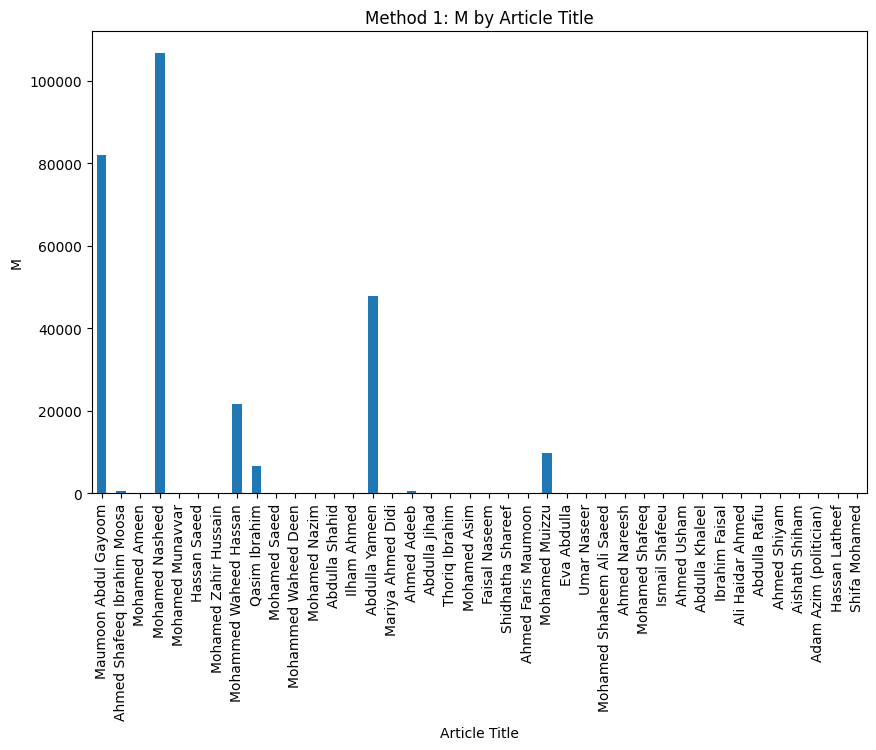

In [6]:
import matplotlib.pyplot as plt

# Assuming article_controversiality_df is a DataFrame with 'article_title' and 'M' as its columns
plt.figure(figsize=(10,6))
article_controversiality_df.set_index('Article Title')['M'].plot(kind='bar')
plt.title('Method 1: M by Article Title')
plt.xlabel('Article Title')
plt.ylabel('M')
plt.show()

# Time based

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'combined_articles.csv'
df = pd.read_csv(file_path)

# Convert the timestamp to datetime for proper sorting
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract month and year
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month

# Initialize an empty list to store reverts
reverts = []

# Iterate through each article and month
for article_id in df['Article ID'].unique():
    article_revisions = df[df['Article ID'] == article_id]
    
    for year in article_revisions['Year'].unique():
        for month in article_revisions['Month'].unique():
            monthly_revisions = article_revisions[(article_revisions['Year'] == year) & (article_revisions['Month'] == month)].reset_index(drop=True)
            
            # Use a sliding window to compare revisions
            for i in range(2, len(monthly_revisions)):
                if monthly_revisions.loc[i, 'User/IP'] != monthly_revisions.loc[i-2, 'User/IP']:

                    if monthly_revisions.loc[i, 'Revised Text'] == monthly_revisions.loc[i-2, 'Revised Text']:
                        reverts.append({
                            'Article ID': article_id,
                            'Year': year,
                            'Month': month,
                            'Reverter': monthly_revisions.loc[i, 'User/IP'],
                            'Reverted': monthly_revisions.loc[i-1, 'User/IP'],
                            'Reverter Index': i,
                            'Reverted Index': i-1
                        })

reverts_df = pd.DataFrame(reverts)

# Calculate total number of edits for each user in each article by month
user_edit_counts = df.groupby(['Article ID', 'Year', 'Month', 'User/IP']).size().reset_index(name='Total Edits')

# Merge the edit counts with the reverts dataframe
reverts_df = reverts_df.merge(user_edit_counts, left_on=['Article ID', 'Year', 'Month', 'Reverter'], right_on=['Article ID', 'Year', 'Month', 'User/IP'])
reverts_df = reverts_df.rename(columns={'Total Edits': 'Reverter Total Edits'})
reverts_df = reverts_df.merge(user_edit_counts, left_on=['Article ID', 'Year', 'Month', 'Reverted'], right_on=['Article ID', 'Year', 'Month', 'User/IP'])
reverts_df = reverts_df.rename(columns={'Total Edits': 'Reverted Total Edits'})

# Exclude self-reverts
reverts_df = reverts_df[reverts_df['Reverter'] != reverts_df['Reverted']]

# Create the pairs (N^d_i, N^r_j)
reverts_df['Pair'] = list(zip(reverts_df['Reverted Total Edits'], reverts_df['Reverter Total Edits']))

# Calculate M_r as the sum of the minimum of N^d and N^r for each revert by month
reverts_df['Min Edits'] = reverts_df.apply(lambda row: min(row['Reverted Total Edits'], row['Reverter Total Edits']), axis=1)
monthly_M_r = reverts_df.groupby(['Article ID', 'Year', 'Month'])['Min Edits'].sum().reset_index(name='M_r')

# Calculate the number of unique editors who ever reverted mutually
unique_editors = reverts_df.groupby(['Article ID', 'Year', 'Month']).apply(lambda x: len(pd.concat([x['Reverter'], x['Reverted']]).unique())).reset_index(name='E')

# Merge the editor count with monthly M_r
monthly_M = monthly_M_r.merge(unique_editors, on=['Article ID', 'Year', 'Month'])

# Compute M_i
monthly_M['M_i'] = monthly_M['E'] * monthly_M['M_r']

# Censure the topmost mutually reverting editors
def censured_M_r(group):
    max_edits = max(group['Reverted Total Edits'].max(), group['Reverter Total Edits'].max())
    censured_reverts = group[(group['Reverted Total Edits'] < max_edits) & (group['Reverter Total Edits'] < max_edits)]
    censured_reverts['Min Edits'] = censured_reverts.apply(lambda row: min(row['Reverted Total Edits'], row['Reverter Total Edits']), axis=1)
    return censured_reverts['Min Edits'].sum()

censured_M_r_by_month = reverts_df.groupby(['Article ID', 'Year', 'Month']).apply(censured_M_r).reset_index(name='censured_M_r')

# Merge censured M_r with the monthly M DataFrame
monthly_M = monthly_M.merge(censured_M_r_by_month, on=['Article ID', 'Year', 'Month'])

# Compute the final measure of controversiality M
monthly_M['M'] = monthly_M['E'] * monthly_M['censured_M_r']

# Get the unique article titles and IDs
article_titles = df[['Article ID', 'Article Title']].drop_duplicates()

# Merge the article titles with the monthly_M dataframe
monthly_M = monthly_M.merge(article_titles, on='Article ID')

# Reorder columns for better readability
monthly_M = monthly_M[['Article ID', 'Article Title', 'Year', 'Month', 'M_r', 'M_i', 'M']]




/var/folders/5z/cnfqktn11n165g1nt0bbmbrh0000gn/T/ipykernel_52168/830157544.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_editors = reverts_df.groupby(['Article ID', 'Year', 'Month']).apply(lambda x: len(pd.concat([x['Reverter'], x['Reverted']]).unique())).reset_index(name='E')
/var/folders/5z/cnfqktn11n165g1nt0bbmbrh0000gn/T/ipykernel_52168/830157544.py:78: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this w

/var/folders/5z/cnfqktn11n165g1nt0bbmbrh0000gn/T/ipykernel_52168/618391753.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_data['Month-Year'] = article_data['Year'].astype(str) + '-' + article_data['Month'].astype(str)


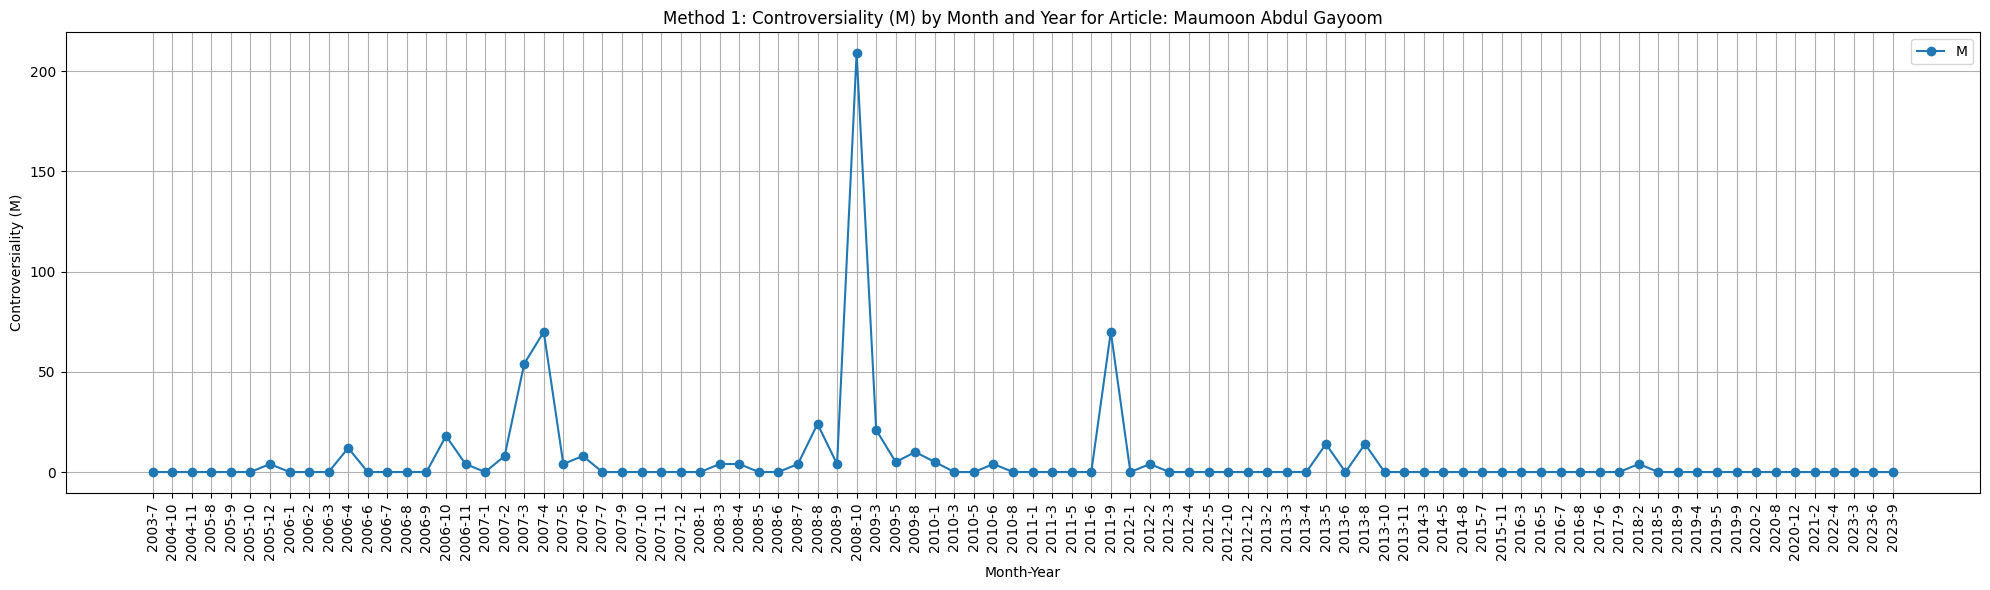

/var/folders/5z/cnfqktn11n165g1nt0bbmbrh0000gn/T/ipykernel_52168/618391753.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_data['Month-Year'] = article_data['Year'].astype(str) + '-' + article_data['Month'].astype(str)


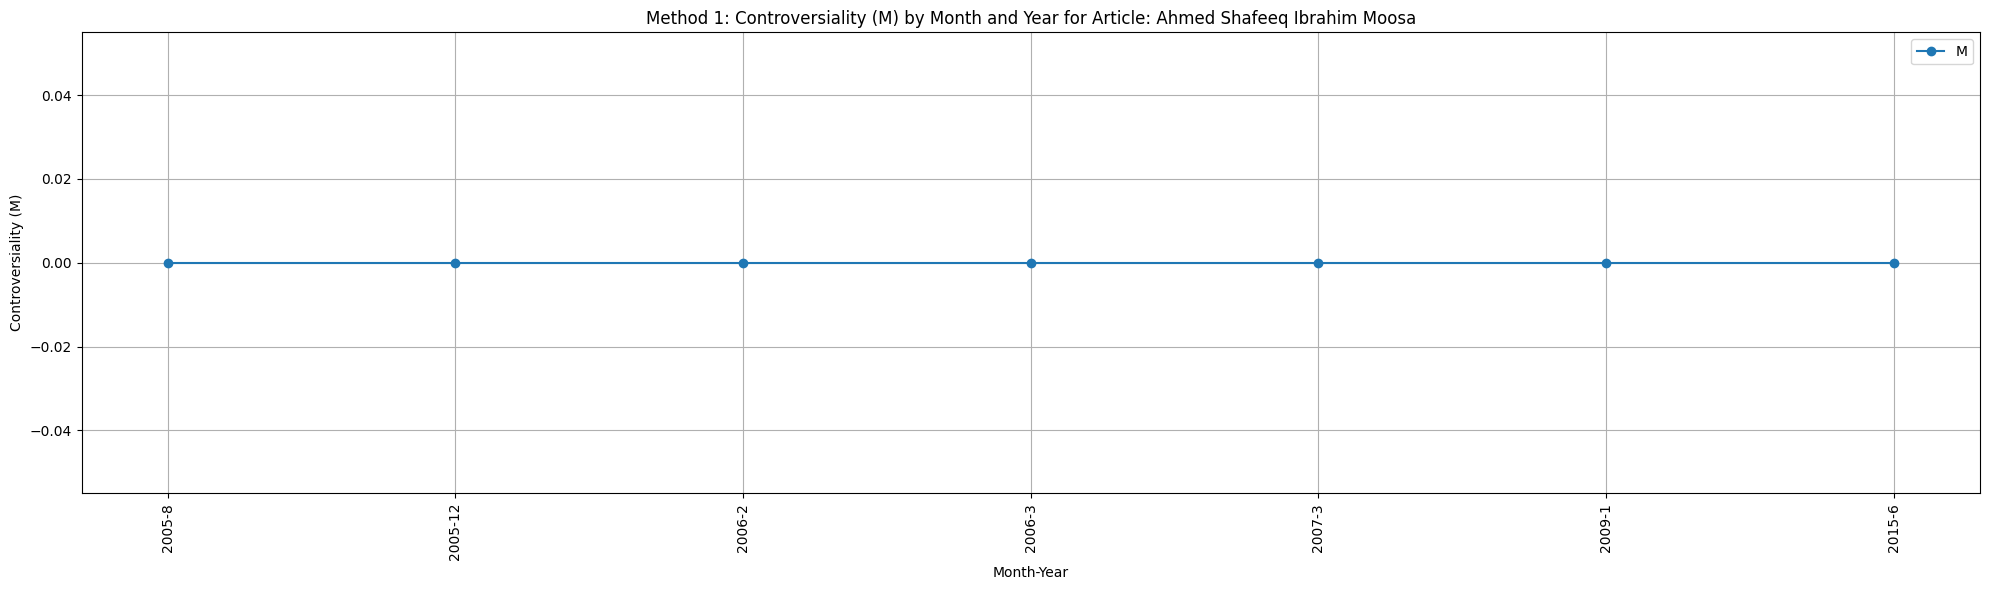

/var/folders/5z/cnfqktn11n165g1nt0bbmbrh0000gn/T/ipykernel_52168/618391753.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_data['Month-Year'] = article_data['Year'].astype(str) + '-' + article_data['Month'].astype(str)


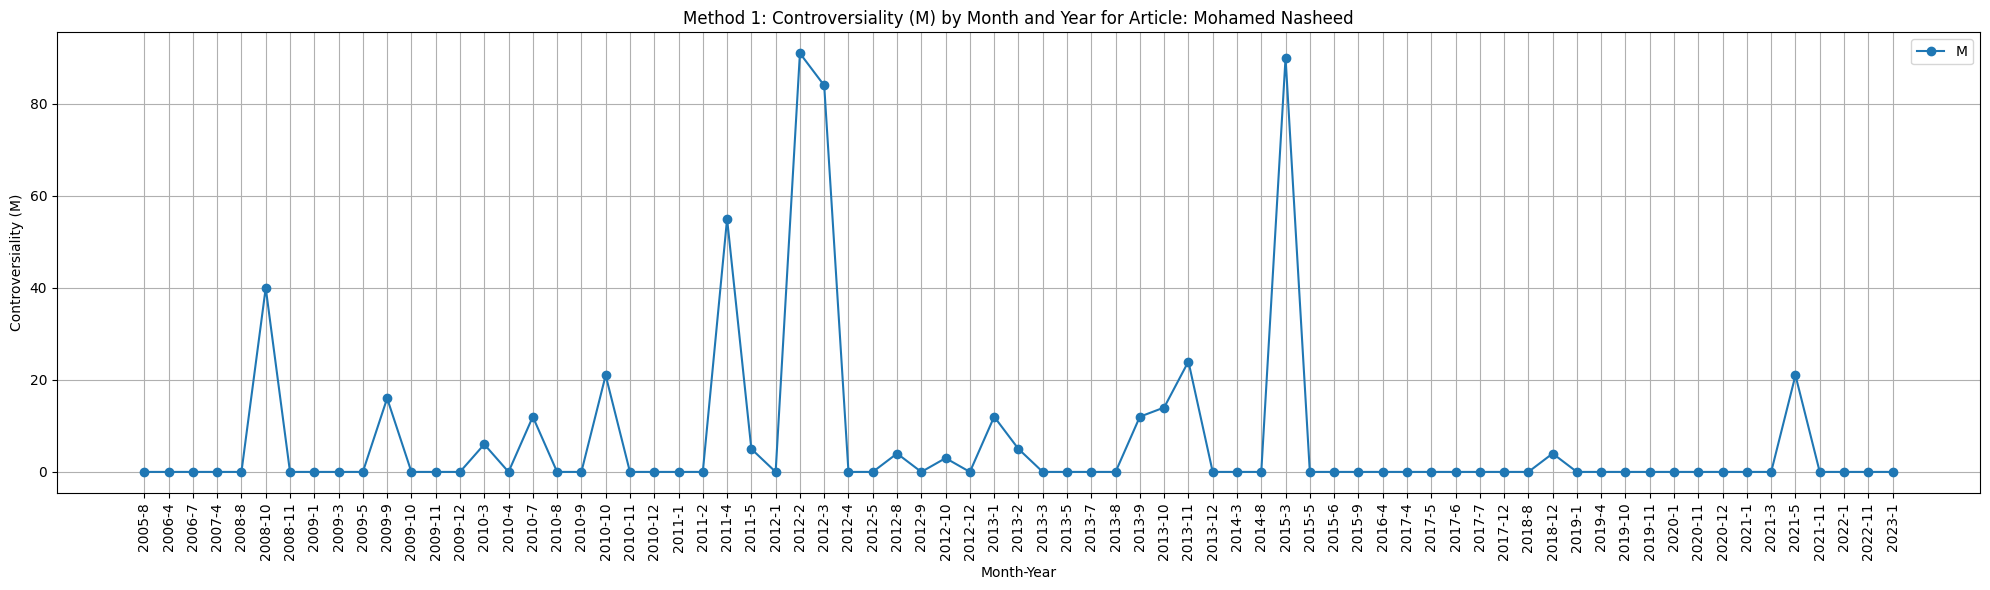

/var/folders/5z/cnfqktn11n165g1nt0bbmbrh0000gn/T/ipykernel_52168/618391753.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_data['Month-Year'] = article_data['Year'].astype(str) + '-' + article_data['Month'].astype(str)


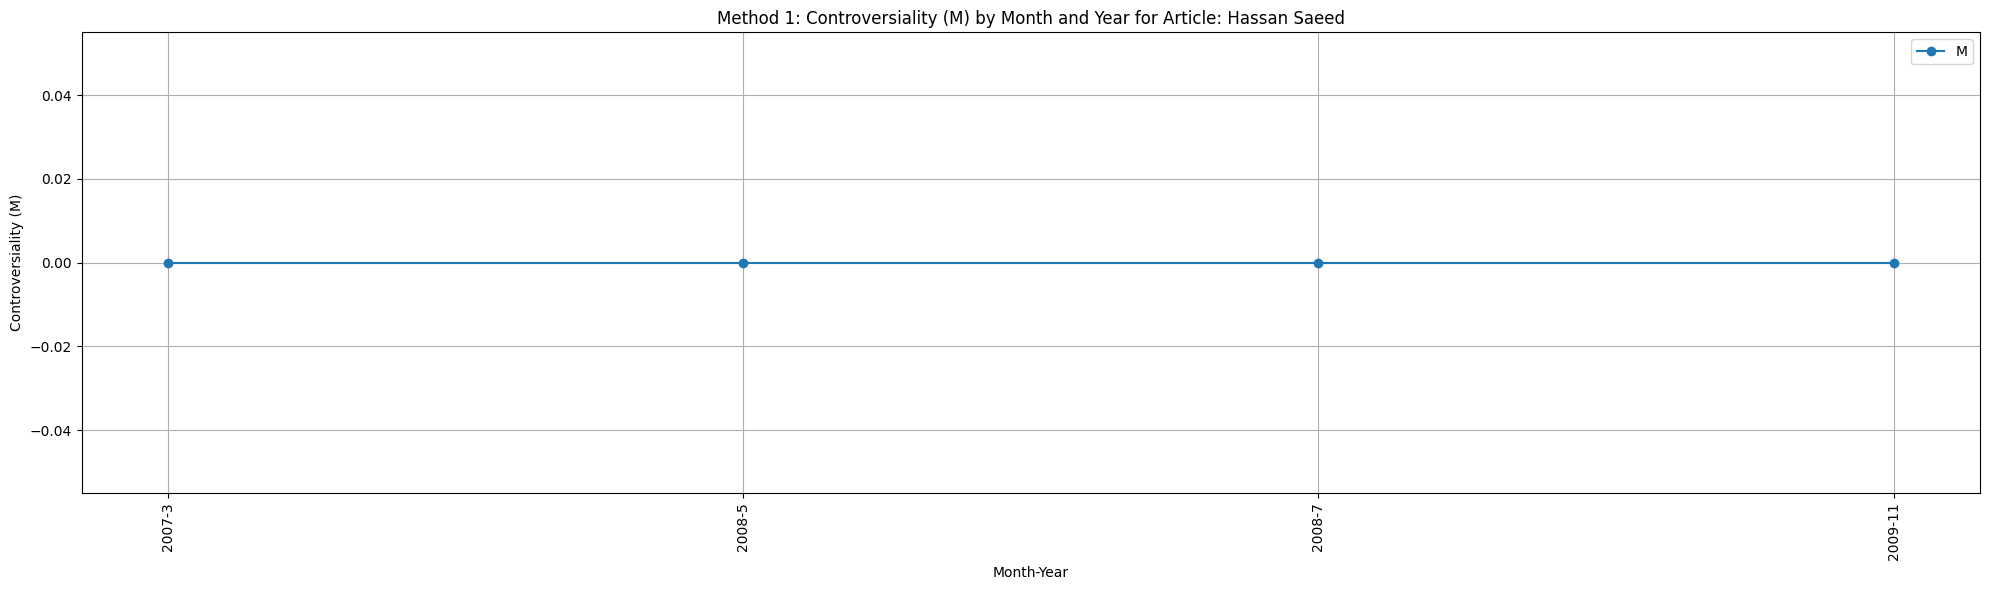

/var/folders/5z/cnfqktn11n165g1nt0bbmbrh0000gn/T/ipykernel_52168/618391753.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_data['Month-Year'] = article_data['Year'].astype(str) + '-' + article_data['Month'].astype(str)


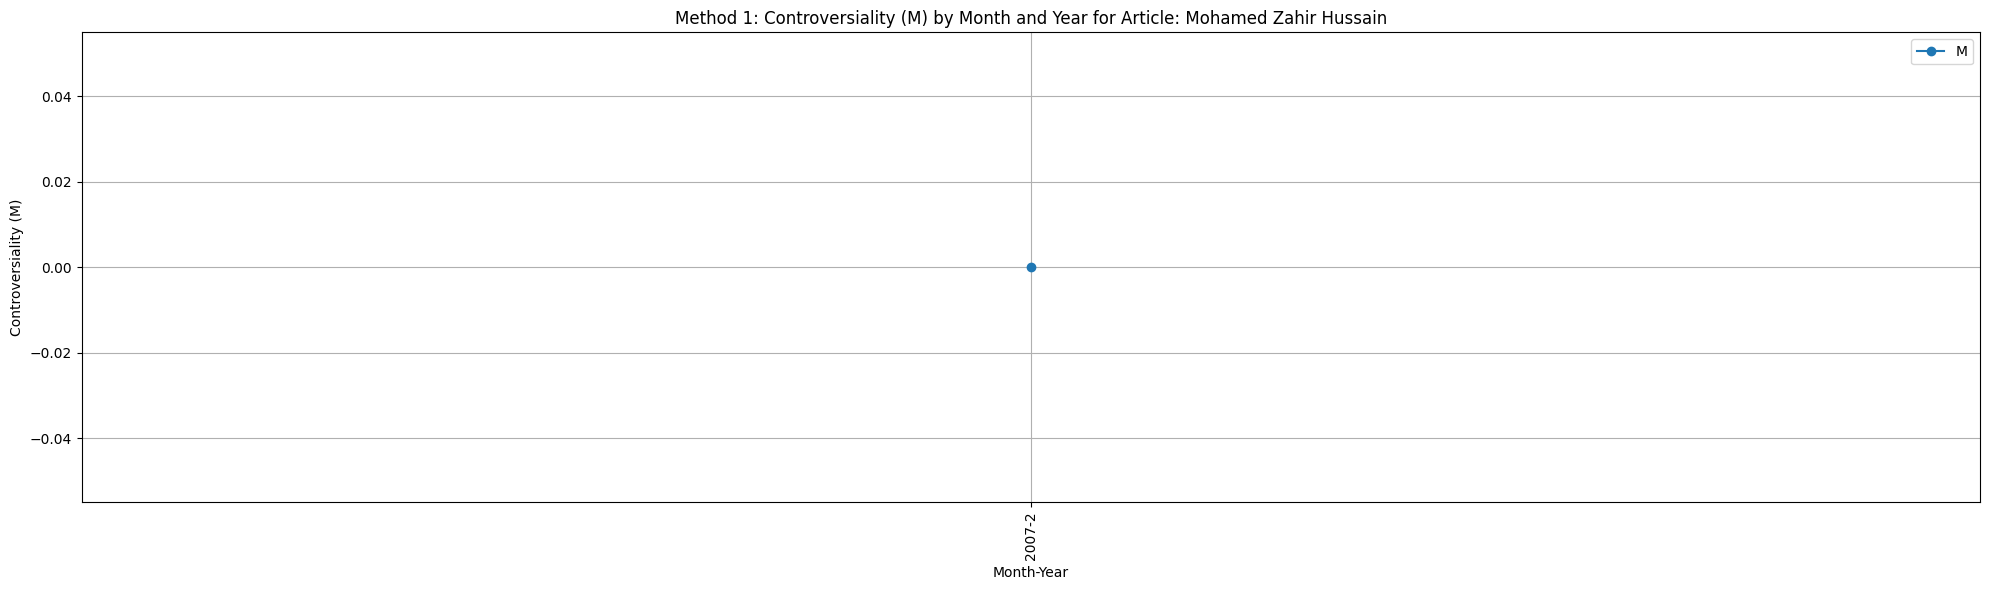

/var/folders/5z/cnfqktn11n165g1nt0bbmbrh0000gn/T/ipykernel_52168/618391753.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_data['Month-Year'] = article_data['Year'].astype(str) + '-' + article_data['Month'].astype(str)


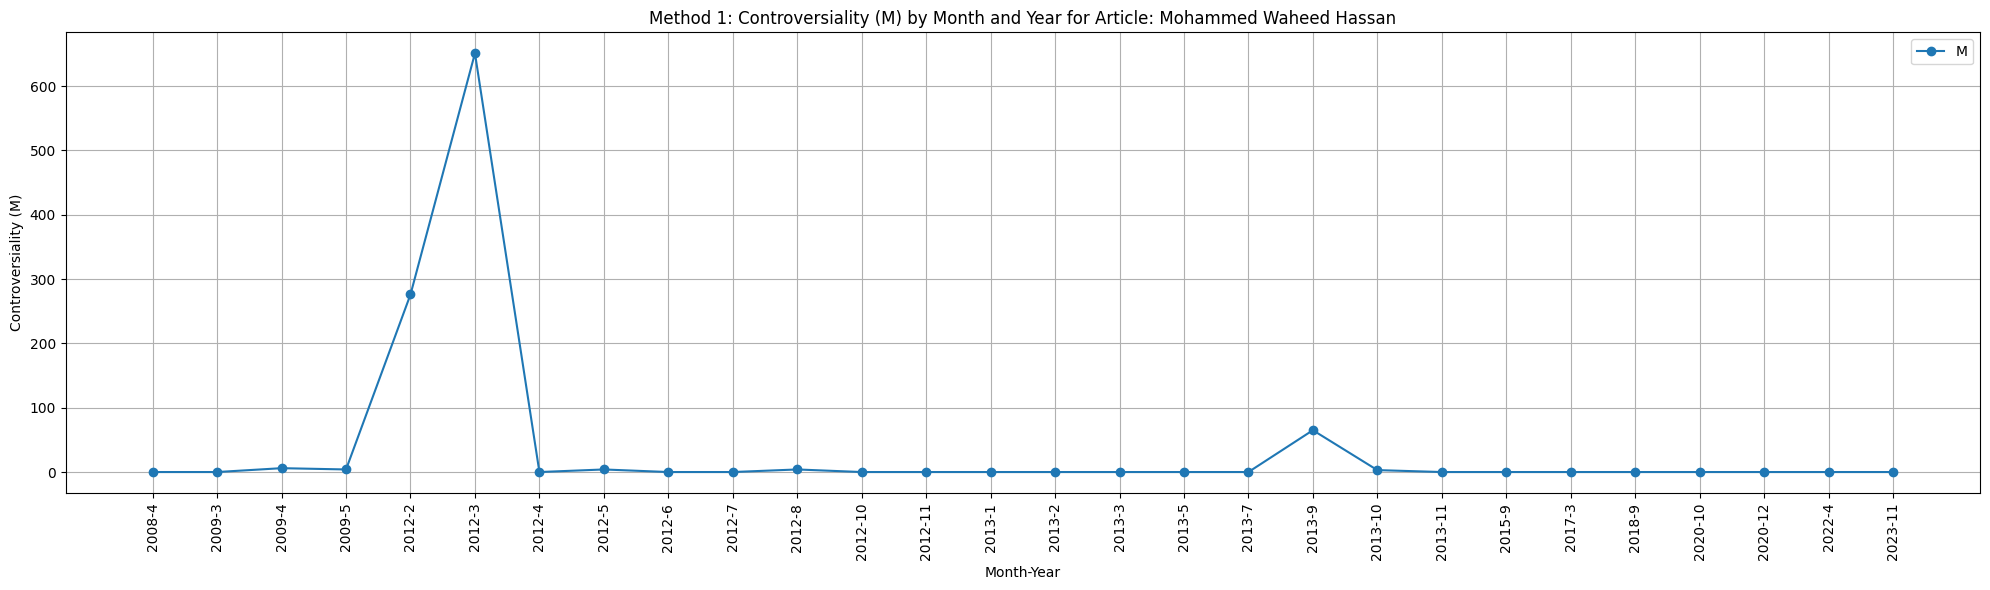

/var/folders/5z/cnfqktn11n165g1nt0bbmbrh0000gn/T/ipykernel_52168/618391753.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_data['Month-Year'] = article_data['Year'].astype(str) + '-' + article_data['Month'].astype(str)


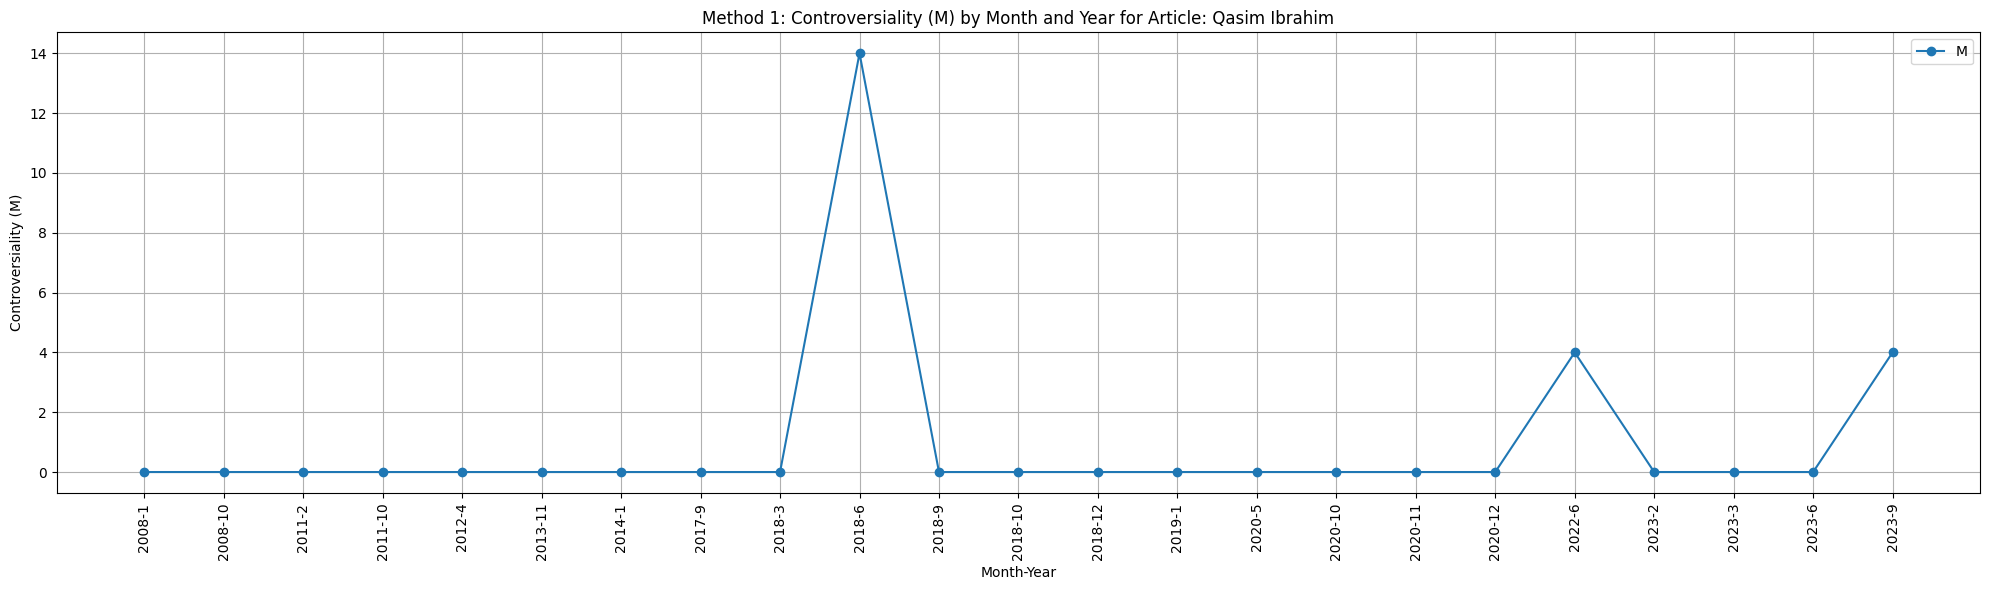

/var/folders/5z/cnfqktn11n165g1nt0bbmbrh0000gn/T/ipykernel_52168/618391753.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_data['Month-Year'] = article_data['Year'].astype(str) + '-' + article_data['Month'].astype(str)


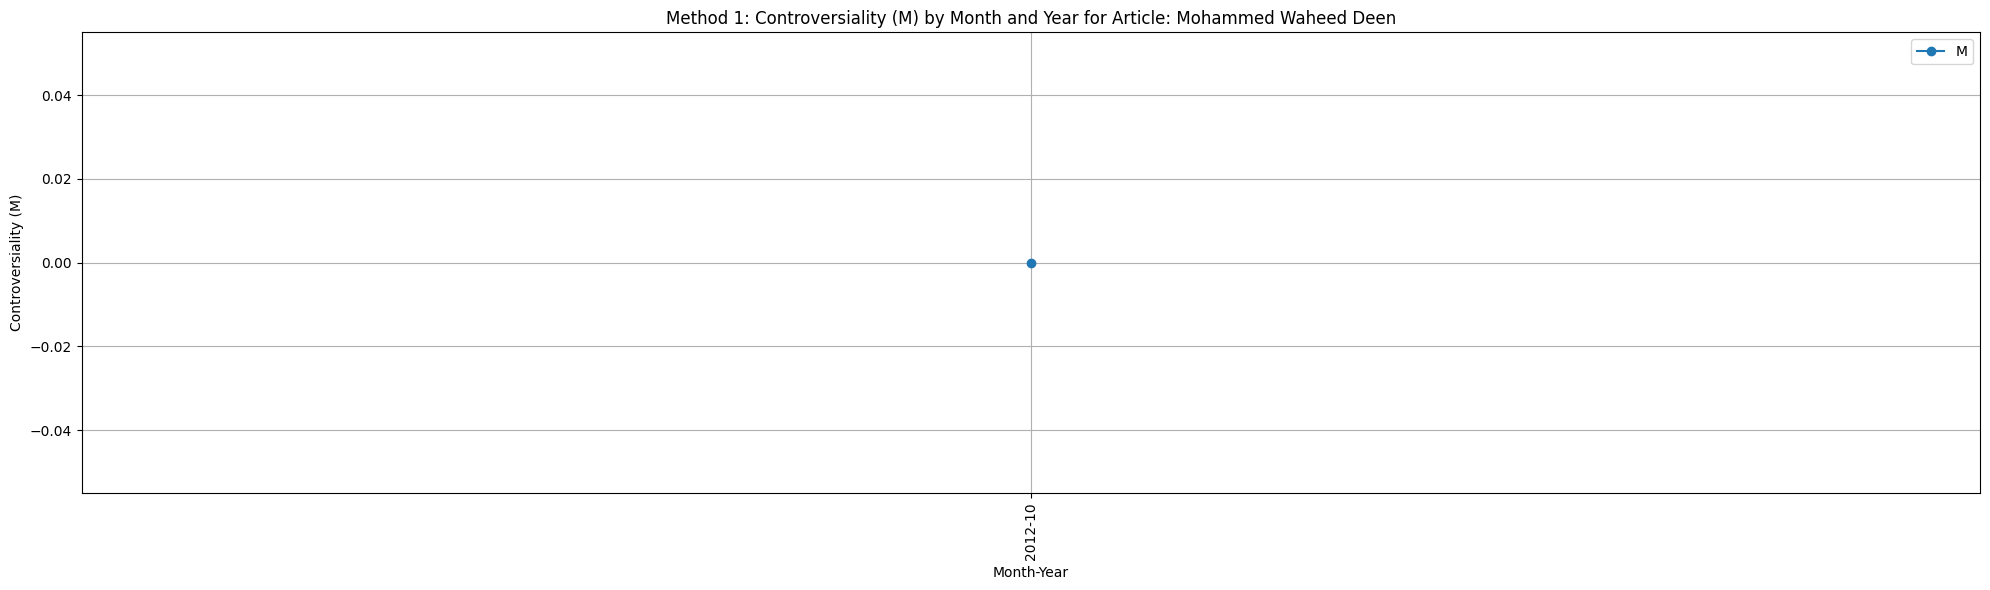

/var/folders/5z/cnfqktn11n165g1nt0bbmbrh0000gn/T/ipykernel_52168/618391753.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_data['Month-Year'] = article_data['Year'].astype(str) + '-' + article_data['Month'].astype(str)


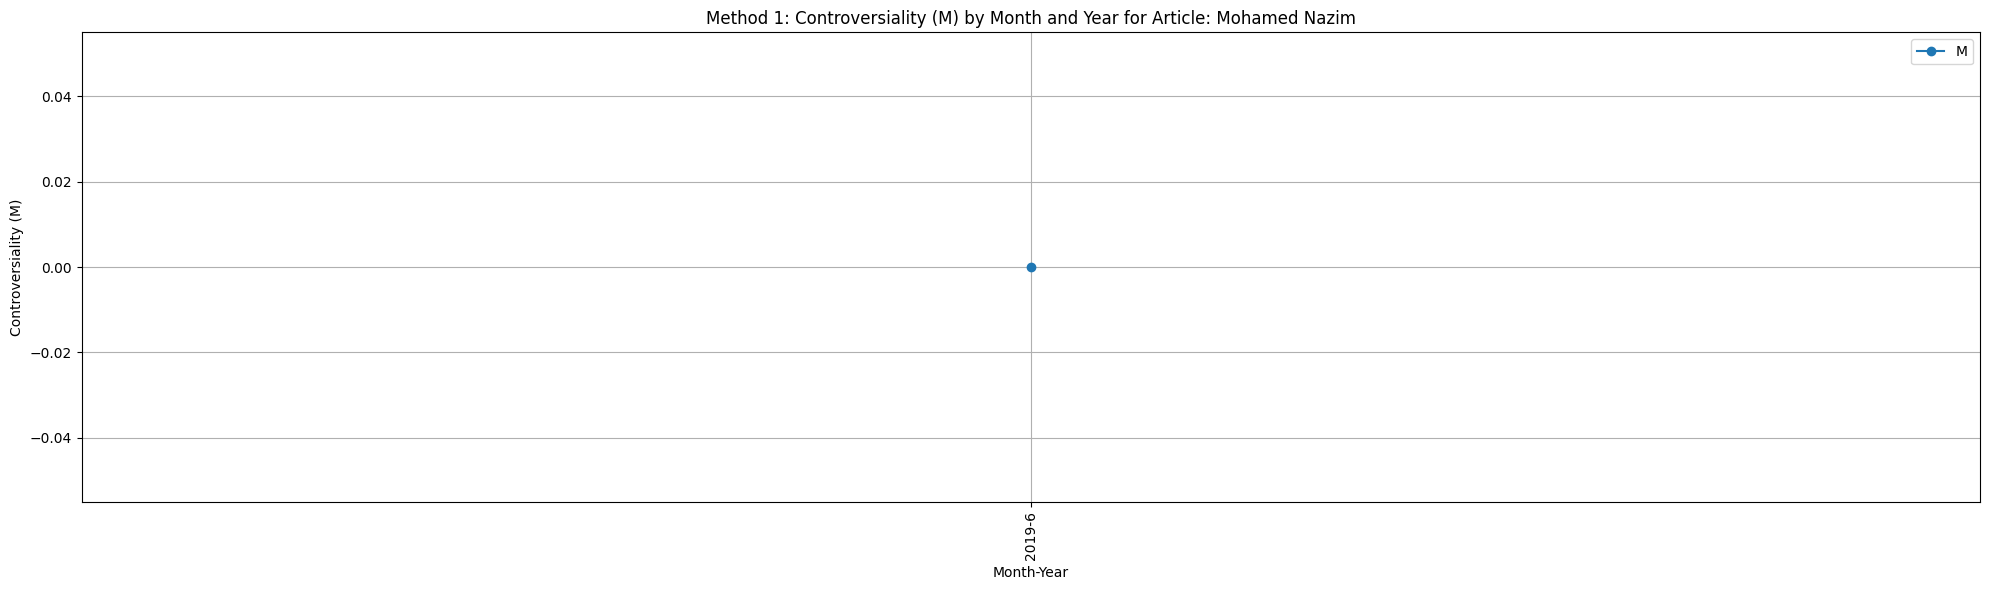

/var/folders/5z/cnfqktn11n165g1nt0bbmbrh0000gn/T/ipykernel_52168/618391753.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_data['Month-Year'] = article_data['Year'].astype(str) + '-' + article_data['Month'].astype(str)


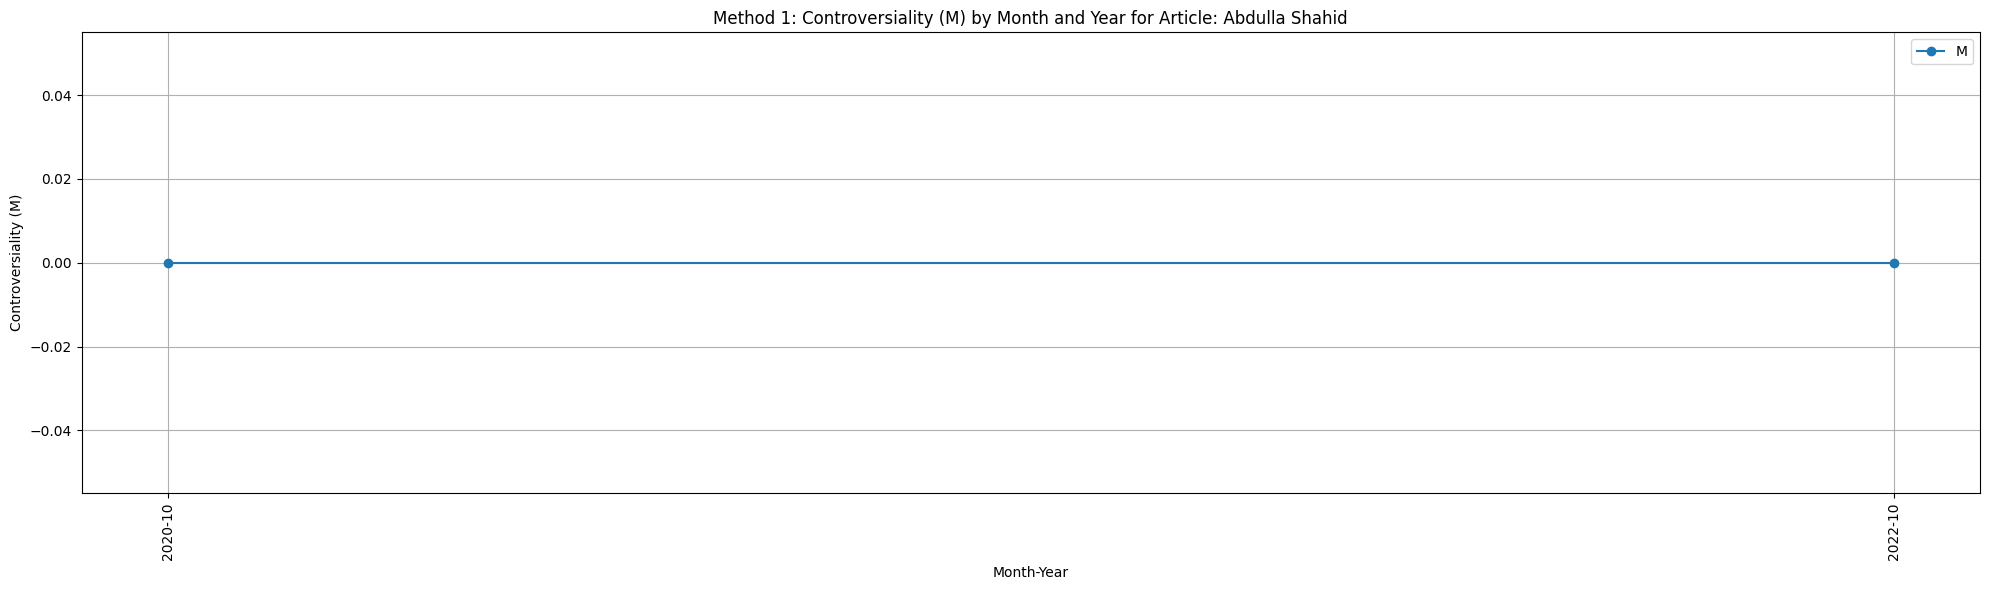

/var/folders/5z/cnfqktn11n165g1nt0bbmbrh0000gn/T/ipykernel_52168/618391753.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_data['Month-Year'] = article_data['Year'].astype(str) + '-' + article_data['Month'].astype(str)


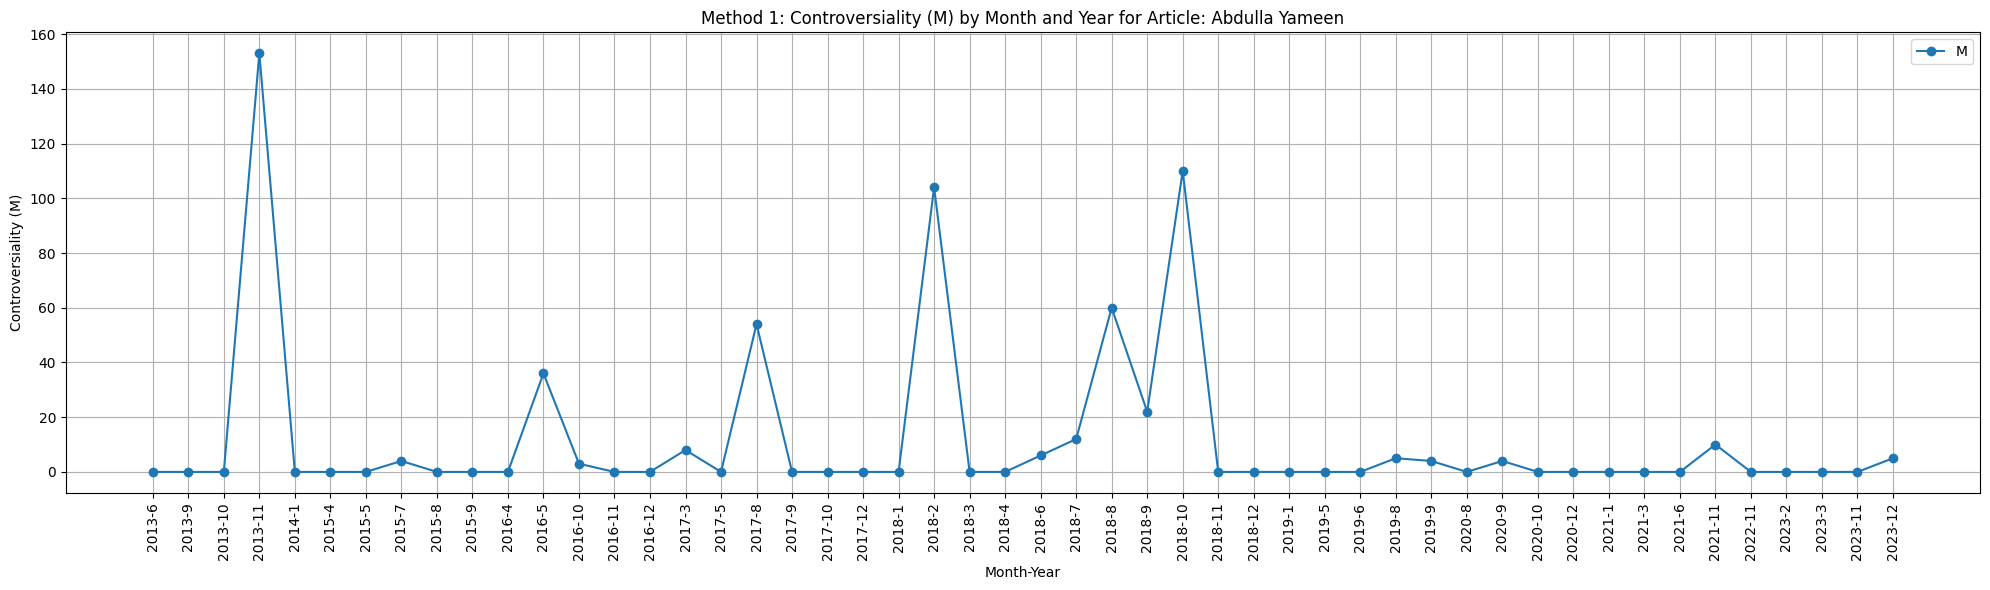

/var/folders/5z/cnfqktn11n165g1nt0bbmbrh0000gn/T/ipykernel_52168/618391753.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_data['Month-Year'] = article_data['Year'].astype(str) + '-' + article_data['Month'].astype(str)


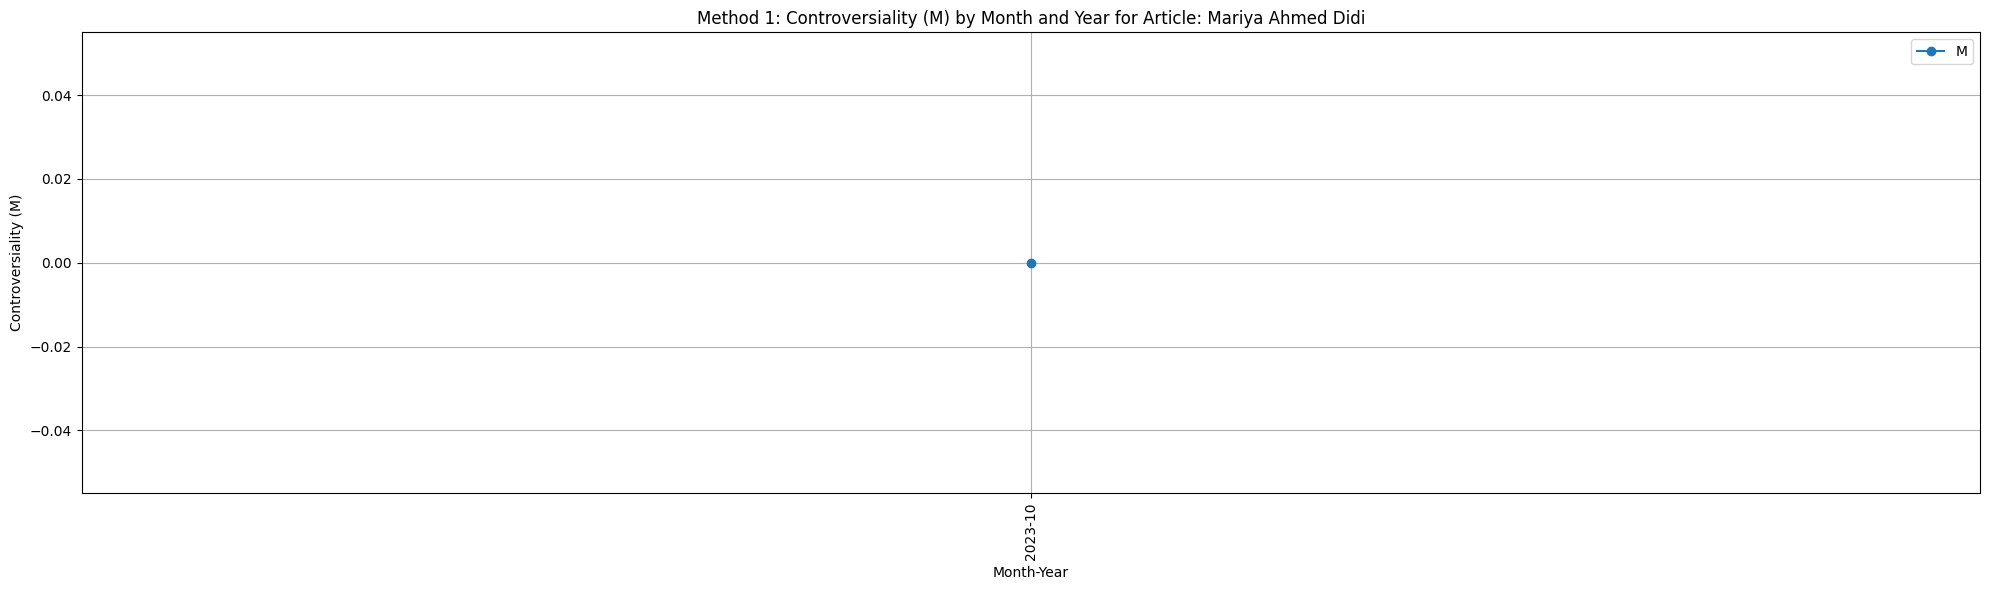

/var/folders/5z/cnfqktn11n165g1nt0bbmbrh0000gn/T/ipykernel_52168/618391753.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_data['Month-Year'] = article_data['Year'].astype(str) + '-' + article_data['Month'].astype(str)


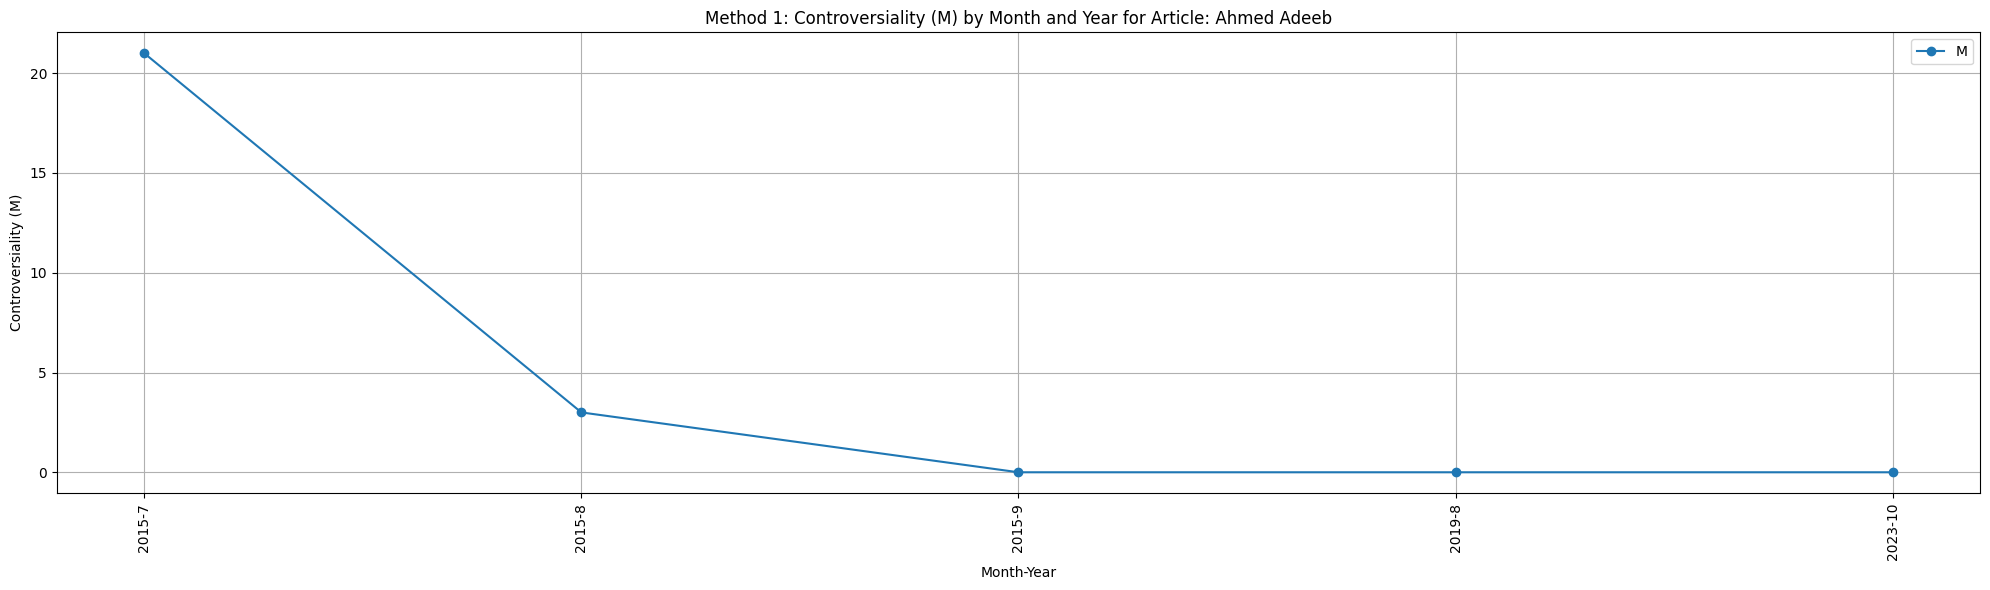

/var/folders/5z/cnfqktn11n165g1nt0bbmbrh0000gn/T/ipykernel_52168/618391753.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_data['Month-Year'] = article_data['Year'].astype(str) + '-' + article_data['Month'].astype(str)


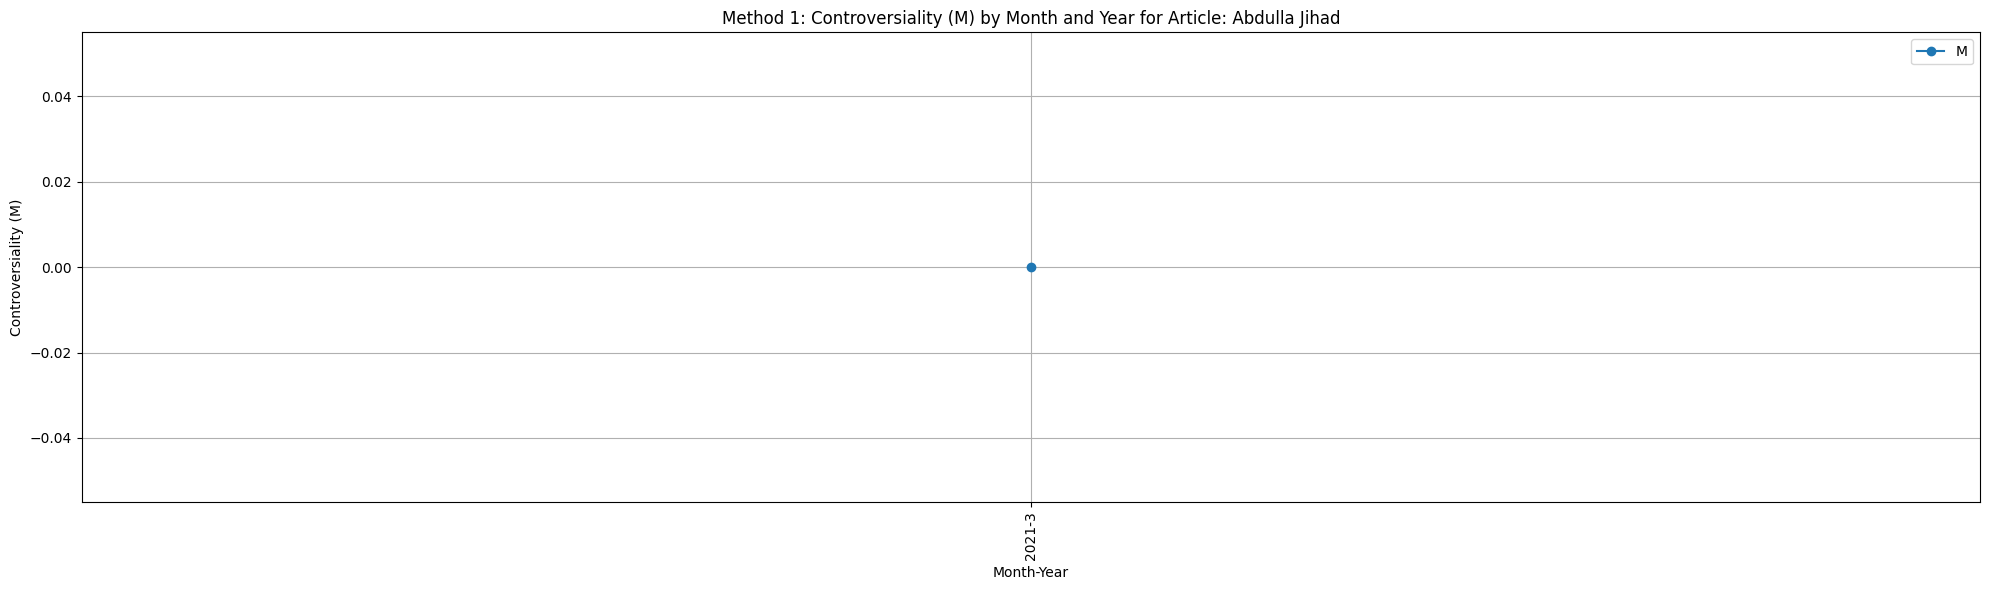

/var/folders/5z/cnfqktn11n165g1nt0bbmbrh0000gn/T/ipykernel_52168/618391753.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_data['Month-Year'] = article_data['Year'].astype(str) + '-' + article_data['Month'].astype(str)


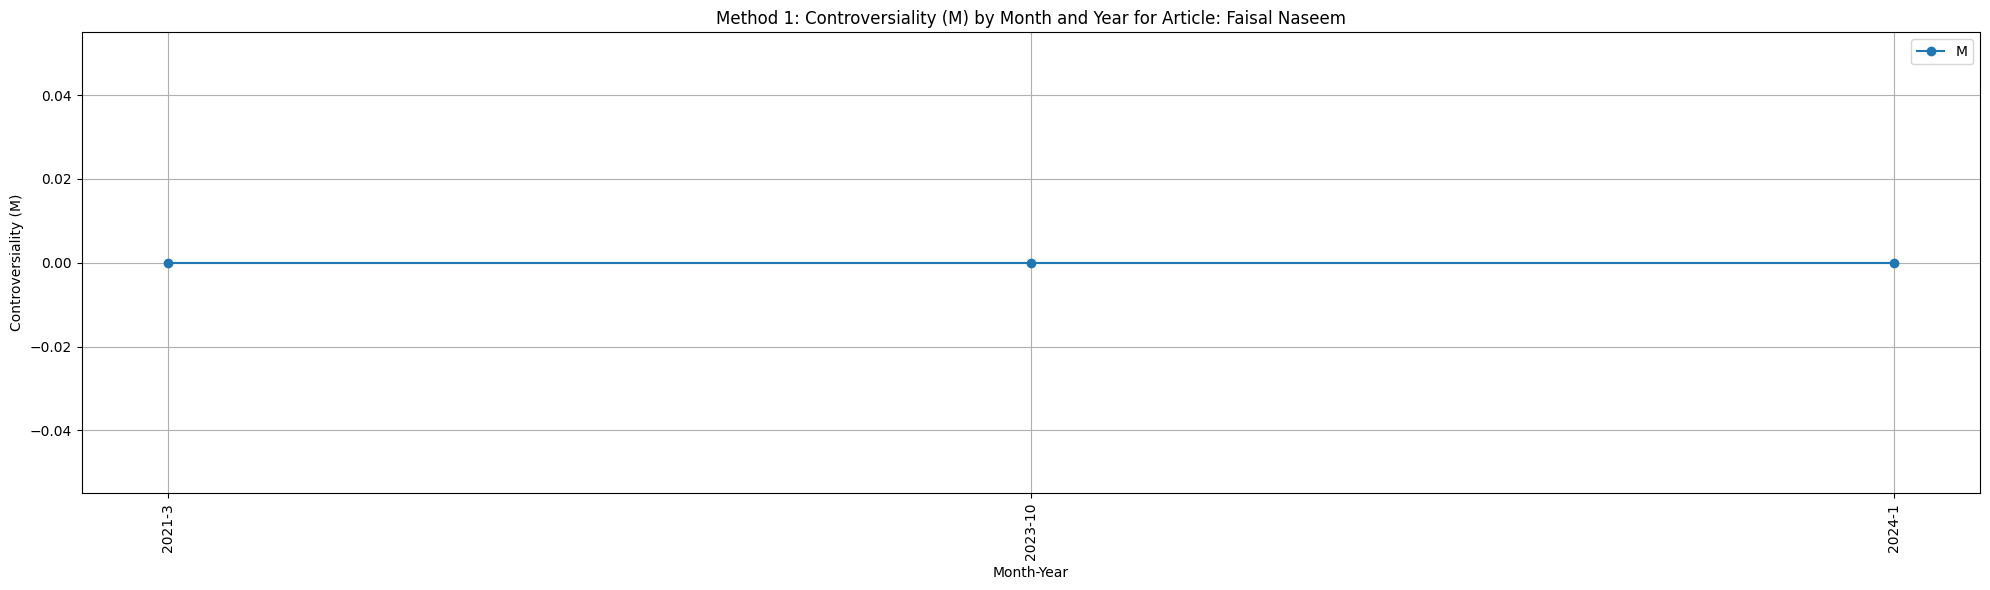

/var/folders/5z/cnfqktn11n165g1nt0bbmbrh0000gn/T/ipykernel_52168/618391753.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_data['Month-Year'] = article_data['Year'].astype(str) + '-' + article_data['Month'].astype(str)


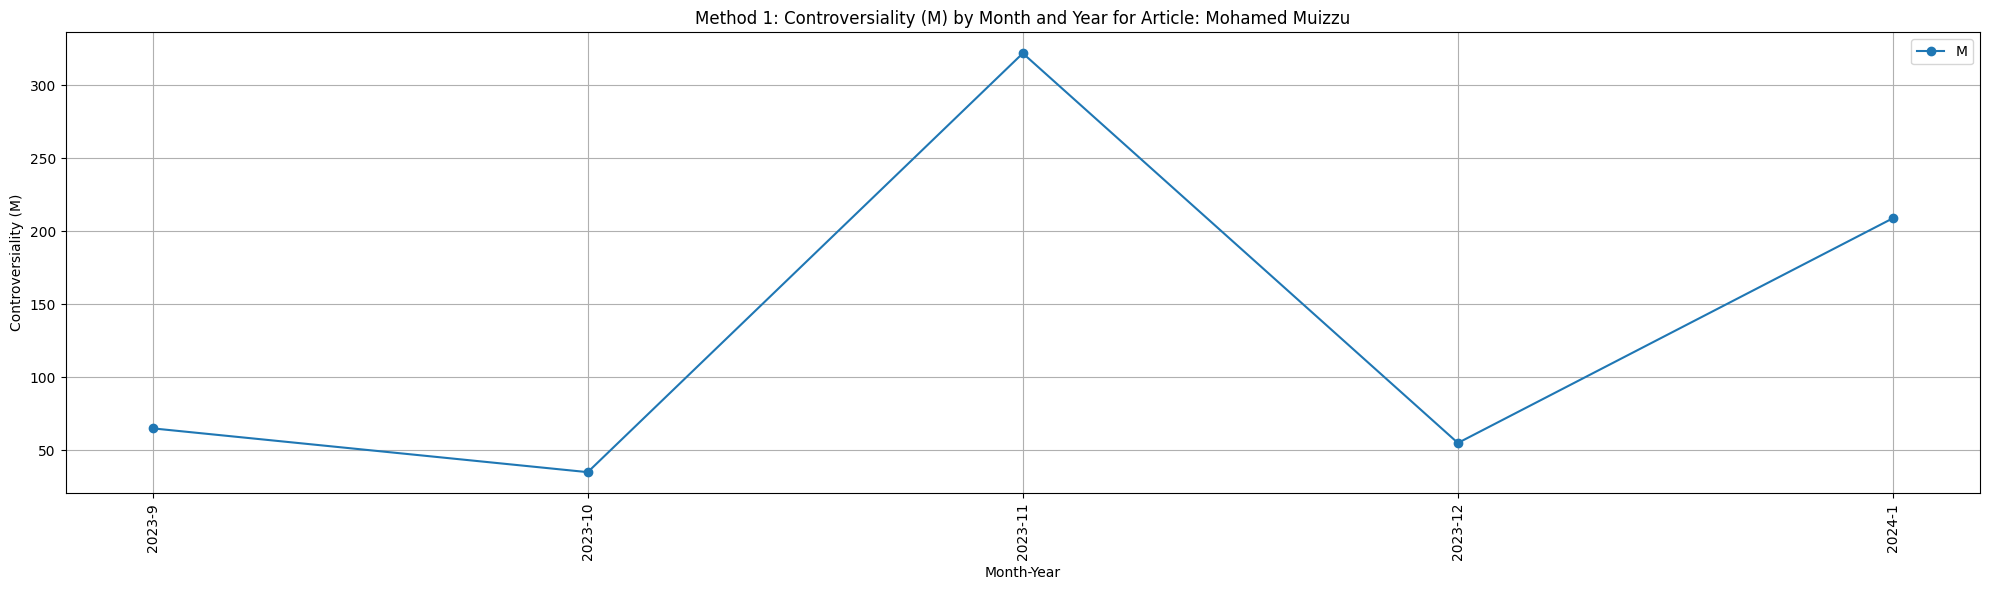

/var/folders/5z/cnfqktn11n165g1nt0bbmbrh0000gn/T/ipykernel_52168/618391753.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_data['Month-Year'] = article_data['Year'].astype(str) + '-' + article_data['Month'].astype(str)


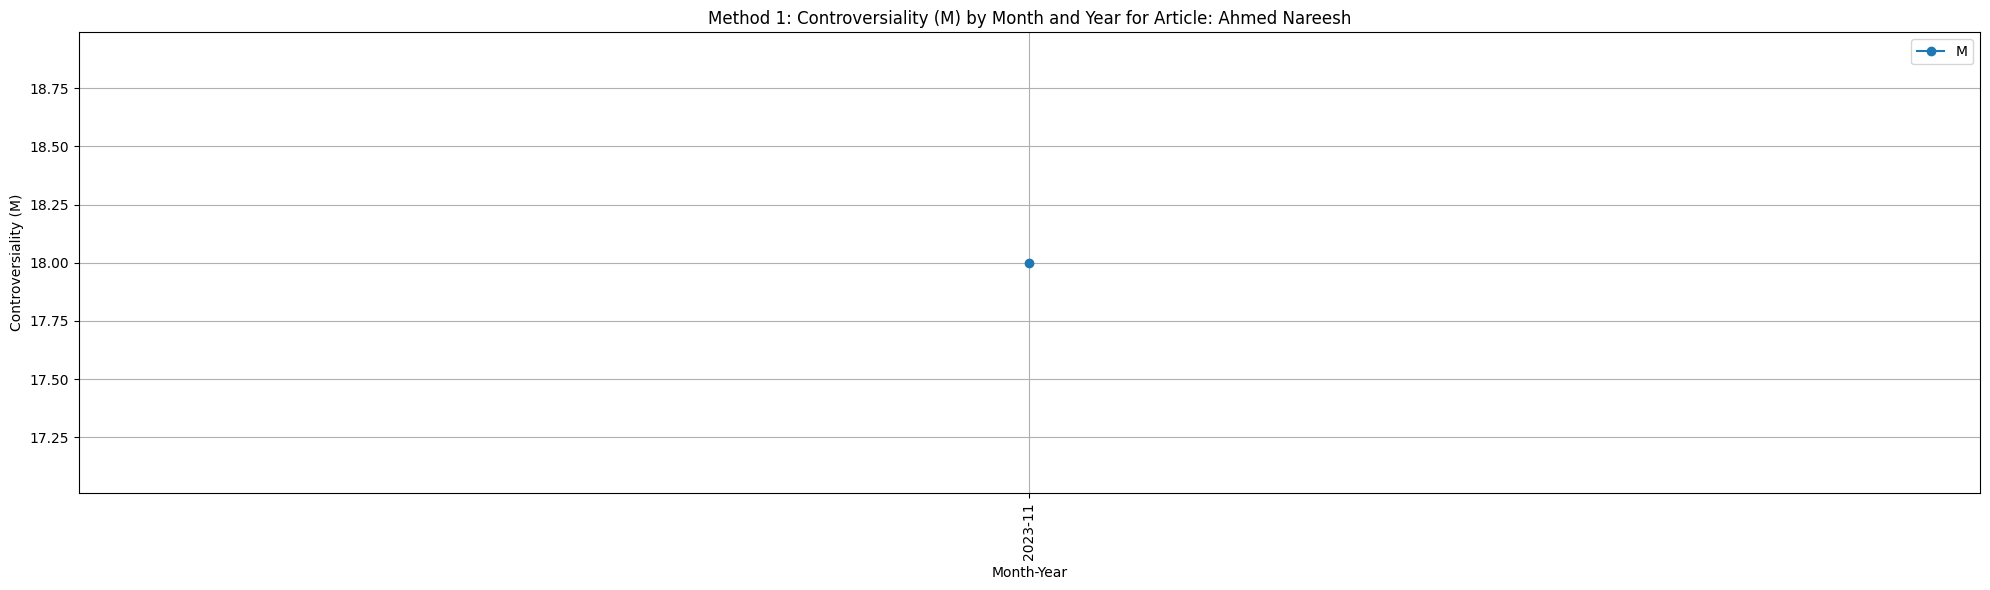

/var/folders/5z/cnfqktn11n165g1nt0bbmbrh0000gn/T/ipykernel_52168/618391753.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_data['Month-Year'] = article_data['Year'].astype(str) + '-' + article_data['Month'].astype(str)


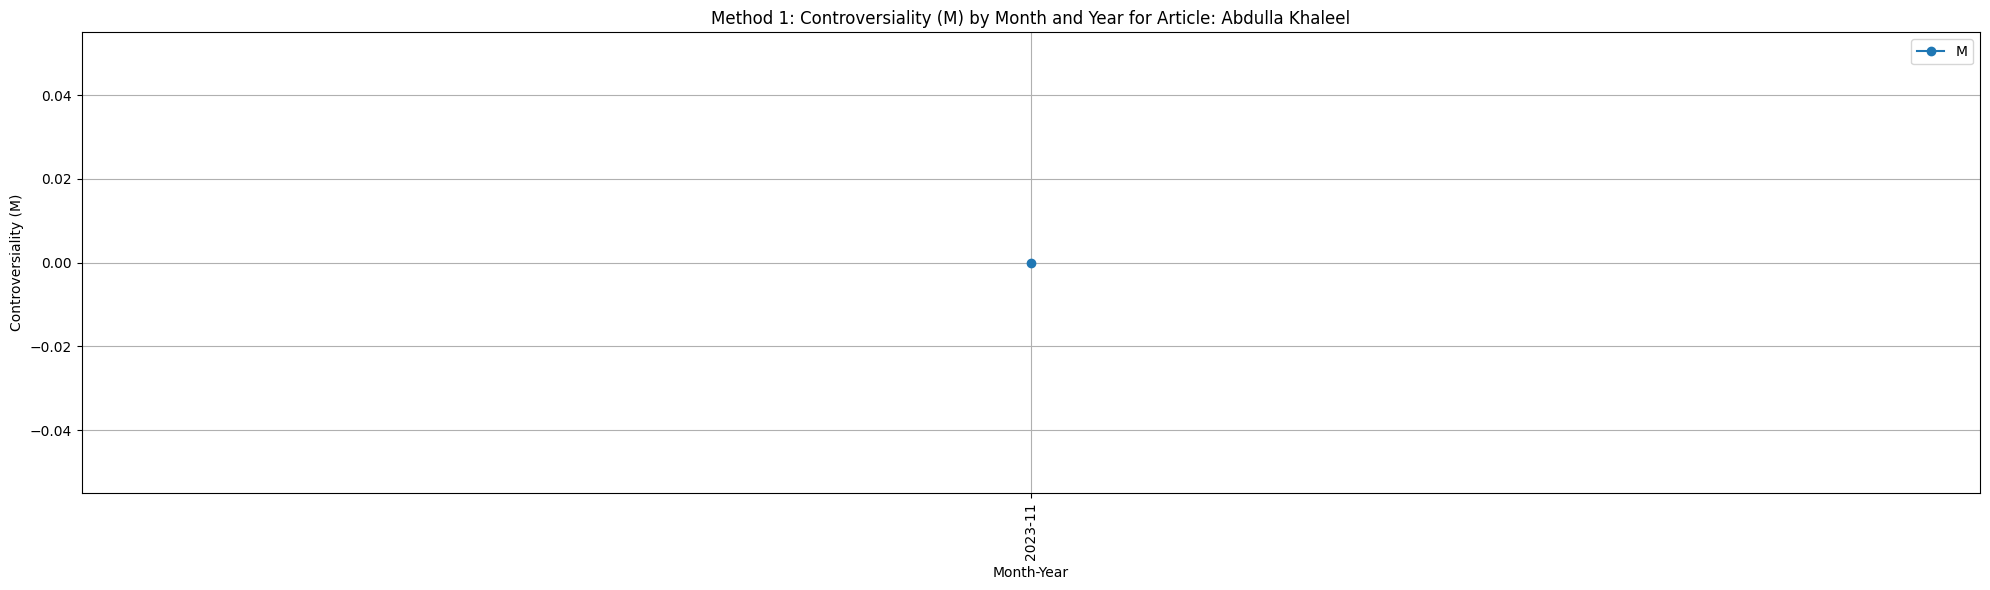

/var/folders/5z/cnfqktn11n165g1nt0bbmbrh0000gn/T/ipykernel_52168/618391753.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_data['Month-Year'] = article_data['Year'].astype(str) + '-' + article_data['Month'].astype(str)


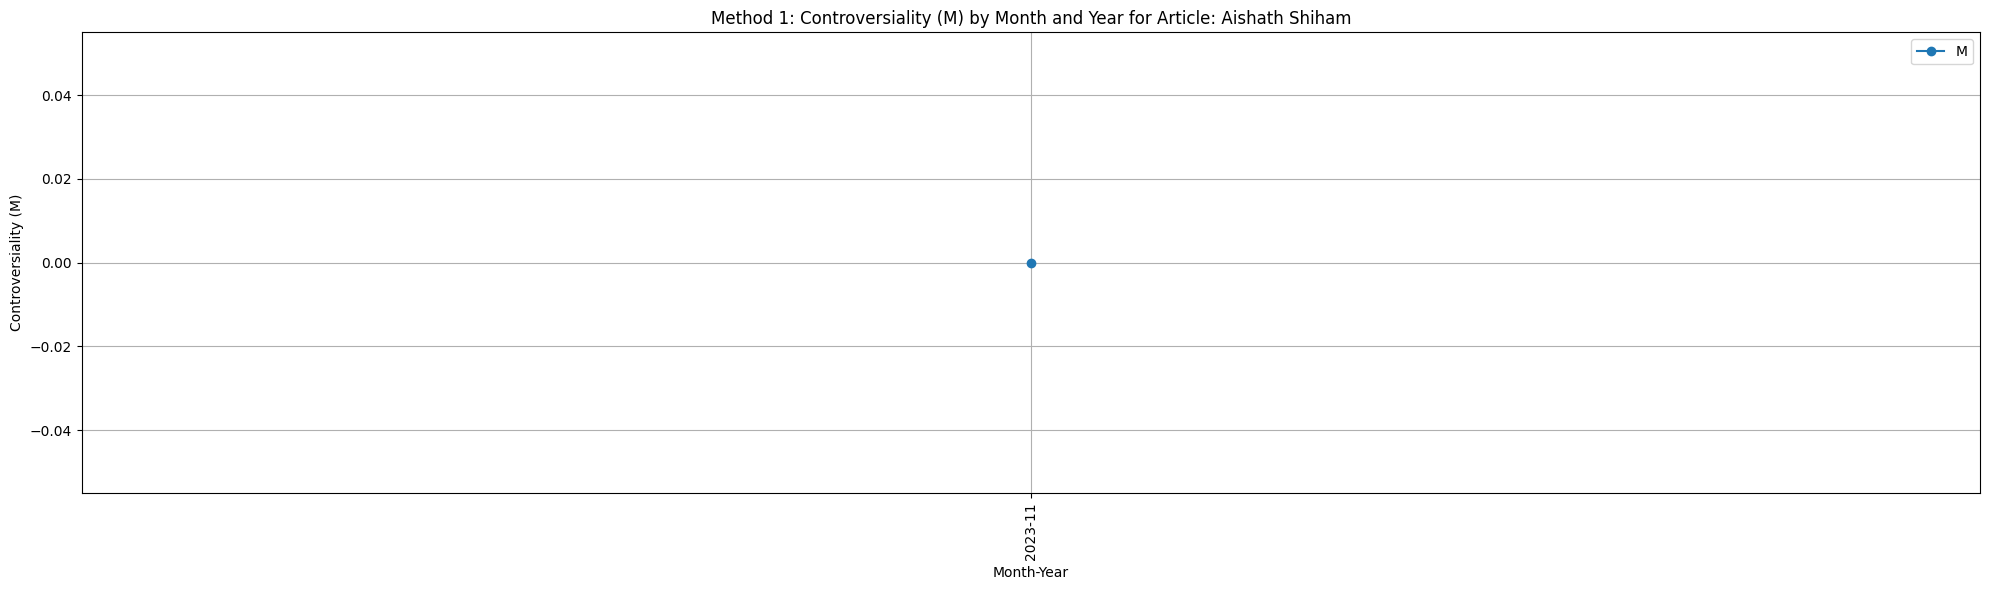

In [8]:
# Function to plot M by month and year for each article
def plot_controversiality_by_month_year(data):
    for article_id in data['Article ID'].unique():
        article_data = data[data['Article ID'] == article_id]
        article_title = article_data['Article Title'].iloc[0]
        plt.figure(figsize=(20, 6))
        # Create a month-year string for the x-axis labels
        article_data['Month-Year'] = article_data['Year'].astype(str) + '-' + article_data['Month'].astype(str)
        plt.plot(article_data['Month-Year'], article_data['M'], marker='o', linestyle='-', label='M')
        plt.title(f'Method 1: Controversiality (M) by Month and Year for Article: {article_title}')
        plt.xlabel('Month-Year')
        plt.ylabel('Controversiality (M)')
        plt.xticks(rotation=90)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Plot the controversiality M by month and year for each article
plot_controversiality_by_month_year(monthly_M)


